In [1]:
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

In [2]:
import cv2
import sys; sys.path.insert(0, '..')

from database.dataset import INBreast_Dataset
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from models.bria2014.haar_extractor import HaarFeatureExtractor
from metrics.metrics import get_tp_fp_fn
from sklearn.model_selection import train_test_split
import general_utils.utils as utils
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
from time import time

db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=1.,
    extract_patches=False,
    extract_patches_method='all',  # 'centered'
    patch_size=256,
    stride=256,
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    partitions=['train', 'validation']
)
BASE_PATH = Path('/home/jseia/Desktop/ml-dl/data_rois/haar_features')
all_features = []
for idx in tqdm(range(30), total=30):
    image_id = db.df.iloc[idx].img_id
    features = pd.read_feather(BASE_PATH/f'{image_id}.fth')
    all_features.append(features)
all_features = np.concatenate(all_features, axis=0)
all_features = pd.DataFrame(all_features, columns=features.columns)
print(all_features.label.value_counts())

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


ModuleNotFoundError: No module named 'models'

In [2]:
all_features = pd.concat([all_features.loc[all_features.label==1], all_features.loc[all_features.label==0].sample(4212)], ignore_index=True)

((336, 21255), 226)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    all_features.loc[:, all_features.columns!='label'].values,
    all_features['label'].values, train_size=0.7,
    random_state=0, stratify=all_features['label'].values)

In [8]:
# Extract all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=14, height=14,
                            feature_type=['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4'])

In [12]:
case = db[idx]
image = case['img']
image_id = db.df.iloc[idx].img_id
radiouses = case['radiuses']
true_bboxes = db[idx]['lesion_bboxes']

dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                    'param1': 300, 'param2': 8,  'minRadius': 2, 'maxRadius': 20}

hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                    'param1': 300, 'param2': 10,  'minRadius': 2, 'maxRadius': 20}
back_ext_radius = 50
erosion_iter = 20
erosion_size = 5

path = Path('/home/jseia/Desktop/ml-dl/data/hough')
path.mkdir(exist_ok=True, parents=True)

hd = HoughCalcificationDetection(
    dehazing_params, back_ext_radius,
    path,
    hough1_params, hough2_params,
    erosion_iter=erosion_iter,
    erosion_size=erosion_size
)
_, h2_circles = hd.detect(
    image, image_id, load_processed_images=True, hough2=True)

tp, fp, fn, gt_d, close_fp = get_tp_fp_fn(true_bboxes, radiouses, h2_circles, 7, 0.0)

h2_circles = np.concatenate((tp, fp), axis=0)

images = np.empty((len(h2_circles), 14, 14))
# generate a patches array to distribute computation
for j, location in enumerate(h2_circles):
    # Get the patch arround center
    x1, x2, y1, y2 = utils.patch_coordinates_from_center(
        center=(location[0], location[1]), image_shape=image.shape,
        patch_size=14, use_padding=False)
    images[j, :, :] = image[y1:y2, x1:x2]

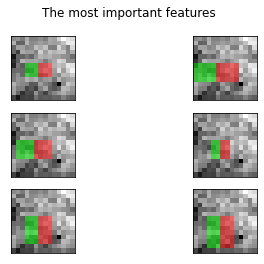

In [15]:
import sys
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

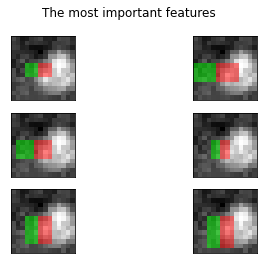

In [17]:
fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = utils.min_max_norm(images[2], 255).astype('uint8')
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

In [18]:
auc_full_features

0.997034479650697

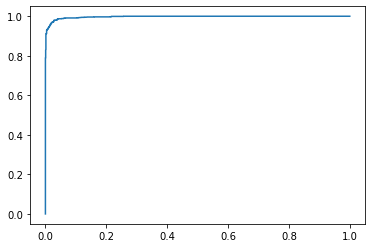

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr)

<AxesSubplot:ylabel='Count'>

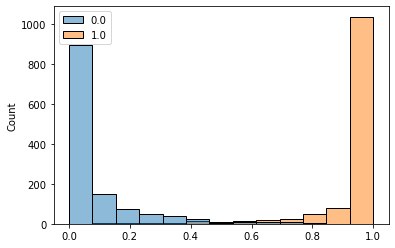

In [20]:
import seaborn as sns
sns.histplot(x=clf.predict_proba(X_test)[:, 1], hue=y_test)

In [21]:
BASE_PATH = Path('/home/jseia/Desktop/ml-dl/data_rois/haar_features')
image_id = db.df.iloc[50].img_id
features_test = pd.read_feather(BASE_PATH/f'{image_id}.fth')

In [ ]:
self.features_r = feature_instantiator(patch_size, 'rot')

In [28]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= cdf_feature_importances[-1]  # divide by max value
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.6)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print((f'{sig_feature_count} features, or {sig_feature_percent}%, '
       f'account for 70% of branch points in the random forest.'))

# Select the determined number of most informative features
# feature_coord_sel = feature_coord[idx_sorted[:sig_feature_count]]
# feature_type_sel = feature_type[idx_sorted[:sig_feature_count]]
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Build the computational graph using Dask
# X = delayed(extract_feature_image(img, feature_type_sel, feature_coord_sel)
#             for img in images)
# # Compute the result
# t_start = time()
# X = np.array(X.compute(scheduler='single-threaded'))
# time_subs_feature_comp = time() - t_start

# y = np.array([1] * len(tp) + [0] * len(fp))
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
#                                                     random_state=0,
#                                                     stratify=y)

2545 features, or 12.0%, account for 70% of branch points in the random forest.


In [16]:
t_start = time()
clf.fit(X_train, y_train)
time_subs_train = time() - t_start

auc_subs_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

summary = ((f'Computing the full feature set took '
            f'{time_full_feature_comp:.3f}s, '
            f'plus {time_full_train:.3f}s training, '
            f'for an AUC of {auc_full_features:.2f}. '
            f'Computing the restricted feature set took '
            f'{time_subs_feature_comp:.3f}s, plus {time_subs_train:.3f}s '
            f'training, for an AUC of {auc_subs_features:.2f}.'))

print(summary)
plt.show()

Computing the full feature set took 48.719s, plus 4.570s training, for an AUC of 1.00. Computing the restricted feature set took 0.638s, plus 2.149s training, for an AUC of 1.00.


In [23]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

51.330018281936646

A random forest classifier can be trained in order to select the most
salient features, specifically for face classification. The idea is to
determine which features are most often used by the ensemble of trees.
By using only the most salient features in subsequent steps, we can
drastically speed up the computation while retaining accuracy.



In [ ]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

We can select the most important features by checking the cumulative sum
of the feature importance. In this example, we keep the features
representing 70% of the cumulative value (which corresponds to using only 3%
of the total number of features).



In [ ]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= cdf_feature_importances[-1]  # divide by max value
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print((f'{sig_feature_count} features, or {sig_feature_percent}%, '
       f'account for 70% of branch points in the random forest.'))

# Select the determined number of most informative features
feature_coord_sel = feature_coord[idx_sorted[:sig_feature_count]]
feature_type_sel = feature_type[idx_sorted[:sig_feature_count]]
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Build the computational graph using Dask
X = delayed(extract_feature_image(img, feature_type_sel, feature_coord_sel)
            for img in images)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='single-threaded'))
time_subs_feature_comp = time() - t_start

y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

Once the features are extracted, we can train and test a new classifier.



In [ ]:
t_start = time()
clf.fit(X_train, y_train)
time_subs_train = time() - t_start

auc_subs_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

summary = ((f'Computing the full feature set took '
            f'{time_full_feature_comp:.3f}s, '
            f'plus {time_full_train:.3f}s training, '
            f'for an AUC of {auc_full_features:.2f}. '
            f'Computing the restricted feature set took '
            f'{time_subs_feature_comp:.3f}s, plus {time_subs_train:.3f}s '
            f'training, for an AUC of {auc_subs_features:.2f}.'))

print(summary)
plt.show()